<a href="https://www.kaggle.com/code/sscarecrow/qwen-2-5-vl-instruct-ocr?scriptVersionId=258550967" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install git+https://github.com/huggingface/transformers accelerate

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-du53_art
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-du53_art
  Resolved https://github.com/huggingface/transformers to commit 304225aa15bdd20e172a7c8df7847d12c52b4e3b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 13.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━

In [2]:
pip install qwen-vl-utils[decord]==0.0.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 42.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 90.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip -q install "transformers>=4.43.0" accelerate sentence-transformers qwen-vl-utils --upgrade




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 9.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.4/483.4 kB 23.3 MB/s eta 0:00:00


In [25]:
import os, json, glob, math, time
from datetime import datetime
from typing import List, Dict

import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

import numpy as np
from sentence_transformers import SentenceTransformer, util as st_util

import matplotlib.pyplot as plt
from PIL import Image

IMG_DIR   = "/kaggle/input/small-1"   
OUT_DIR   = "/kaggle/working/ocr_out"  
os.makedirs(OUT_DIR, exist_ok=True)

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff")

QWEN_ID = "Qwen/Qwen2.5-VL-3B-Instruct"

EMB_MODEL_ID = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

OCR_PROMPT = """Bạn là một chuyên gia nhận diện văn bản (OCR) tiên tiến và có kiến thức sâu rộng về ngôn ngữ tiếng Việt. Nhiệm vụ của bạn là phân tích hình ảnh được cung cấp và trích xuất tất cả các đoạn văn bản (scene text) có trong đó.

**Các yêu cầu cụ thể:**

1.  **Ngôn ngữ mục tiêu:** Văn bản cần được nhận diện hoàn toàn bằng tiếng Việt.
2.  **Độ chính xác cao:**
    *   Hãy cực kỳ chú ý đến độ chính xác của từng ký tự, đặc biệt là các **dấu thanh (sắc, huyền, hỏi, ngã, nặng), dấu câu và các ký tự đặc biệt của tiếng Việt (ví dụ: đ, ư, ơ, â)**.
    *   **Tránh tuyệt đối các lỗi sai lệch do thiếu hoặc nhầm lẫn dấu**. Chú ý sửa lại nếu văn bản nhận diện được không có nghĩa, ví dụ "MÁY TÌN" sửa thành "MÁY TÍNH", "SẠT LỎ" thành "SẠT LỞ".
    *   Ưu tiên độ chính xác tuyệt đối ngay cả khi văn bản hơi mờ hoặc khó đọc một chút.
    *   Yêu cầu trích xuất tất cả văn bản có trong ảnh, không được bỏ sót trường hợp nào.
3.  **Định dạng đầu ra:**
    *   Trình bày kết quả dưới dạng danh sách các dòng văn bản được trích xuất.
    *   Mỗi dòng văn bản nên nằm trên một dòng riêng biệt.
    *   Chỉ trình bày nội dung kết quả, không được thêm bất kỳ câu gì khác, như "Dưới đây là danh sách các dòng văn bản được trích xuất từ hình ảnh:".
    *   Nếu có thể, hãy giữ nguyên thứ tự xuất hiện của văn bản trong hình ảnh (thường là từ trên xuống dưới, từ trái sang phải).
4.  **Xử lý trường hợp đặc biệt:**
    *   Nếu không tìm thấy văn bản nào trong hình ảnh, hãy thông báo rõ ràng: "Không tìm thấy văn bản nào trong hình ảnh này."
    *   Nếu văn bản cực kỳ mờ, nhỏ hoặc khó đọc đến mức bạn không thể nhận diện với độ tin cậy cao, hãy cố gắng hết sức và ghi chú nếu có sự không chắc chắn (ví dụ: "[Không chắc chắn] XYZ").
"""

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def list_images(img_dir: str) -> List[str]:
    files = []
    for ext in IMG_EXTS:
        files.extend(glob.glob(os.path.join(img_dir, f"*{ext}")))
    files = sorted(files)
    print(f"Found {len(files)} images.")
    return files


Using device: cuda


In [26]:

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    QWEN_ID, torch_dtype="auto", device_map="auto"
)

min_pixels = 256 * 28 * 28
max_pixels = 1024 * 28 * 28
processor = AutoProcessor.from_pretrained(
    QWEN_ID, min_pixels=min_pixels, max_pixels=max_pixels
)

_ = torch.cuda.empty_cache() if device == "cuda" else None


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
@torch.inference_mode()
def ocr_one_image(img_path: str, max_new_tokens: int = 512) -> str:
    messages = [
        {
            "role": "user",
            "content": [
                { "type": "image", "image": img_path },
                { "type": "text",  "text": OCR_PROMPT }
            ],
        }
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(device)

    gen_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    trimmed = [out[len(inp):] for inp, out in zip(inputs.input_ids, gen_ids)]
    out_text = processor.batch_decode(trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    out_text = out_text.strip()
    return out_text if out_text else "Không tìm thấy văn bản nào trong hình ảnh này."


In [28]:
img_paths = list_images(IMG_DIR)

ocr_results: List[Dict] = []
start = time.time()
for i, p in enumerate(img_paths, 1):
    t0 = time.time()
    text = ocr_one_image(p)
    ocr_results.append({"image_path": p, "text": text})
    dt = time.time() - t0
    print(f"[{i}/{len(img_paths)}] OCR xong: {os.path.basename(p)} ({dt:.2f}s)")

# Lưu JSON (mỗi phần tử: {image_path, text})
json_path = os.path.join(OUT_DIR, "ocr_results.json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(ocr_results, f, ensure_ascii=False, indent=2)

print(f"Hoàn tất OCR {len(ocr_results)} ảnh trong {time.time()-start:.2f}s")
print(f"Lưu tại: {json_path}")


Found 2 images.
[1/2] OCR xong: 017.jpg (7.56s)
[2/2] OCR xong: 023.jpg (4.73s)
Hoàn tất OCR 2 ảnh trong 12.29s
Lưu tại: /kaggle/working/ocr_out/ocr_results.json


In [29]:
emb_model = SentenceTransformer(EMB_MODEL_ID, device=device)
corpus_texts = [r["text"] for r in ocr_results]

emb_matrix = emb_model.encode(corpus_texts, convert_to_tensor=True, normalize_embeddings=True)
print("Embedding matrix shape:", tuple(emb_matrix.shape))

np.save(os.path.join(OUT_DIR, "embeddings.npy"), emb_matrix.cpu().numpy())
with open(os.path.join(OUT_DIR, "corpus.json"), "w", encoding="utf-8") as f:
    json.dump(ocr_results, f, ensure_ascii=False, indent=2)
print("Đã lưu embeddings & corpus.")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embedding matrix shape: (2, 384)
Đã lưu embeddings & corpus.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


=== Kết quả cho truy vấn: "ôn tập hóa học" ===
 1. score=0.363 | 017.jpg | - CẢNH BÁO
- SẠT LỎ NGUY HIỂM
- TẠM DỪNG LƯU THÔNG
- ĐỐI VỚI XE 3 BÀN TRÔ LÊN
- NGƯỜI DÂN DI LẠI CHÚ Ý QUAN SÁT
 2. score=0.137 | 023.jpg | - Dấu ấn quân đội nhân dân Việt Nam 75 năm xây dựng và trưởng thành


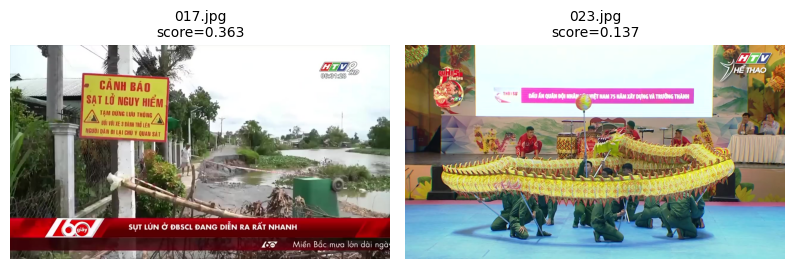

In [30]:
def search_images(
    query: str,
    top_k: int = 6,
    show: bool = True,
    cols: int = 3,
):
    q_emb = emb_model.encode([query], convert_to_tensor=True, normalize_embeddings=True)
    sims = st_util.cos_sim(q_emb, emb_matrix).cpu().numpy().ravel()
    idxs = np.argsort(-sims)[:top_k]  # top-k giảm dần

    results = [(i, float(sims[i]), ocr_results[i]["image_path"], ocr_results[i]["text"]) for i in idxs]

    print(f"\n=== Kết quả cho truy vấn: \"{query}\" ===")
    for rank, (i, score, img_p, txt) in enumerate(results, 1):
        short = (txt[:120] + "…") if len(txt) > 120 else txt
        print(f"{rank:>2}. score={score:.3f} | {os.path.basename(img_p)} | {short}")

    if show:
        rows = math.ceil(len(results) / cols)
        plt.figure(figsize=(4*cols, 4*rows))
        for j, (_, score, img_p, txt) in enumerate(results, 1):
            plt.subplot(rows, cols, j)
            try:
                im = Image.open(img_p).convert("RGB")
            except Exception:
                im = Image.open(img_p)
            plt.imshow(im)
            plt.axis("off")
            # Caption ngắn gọn
            cap = f"{os.path.basename(img_p)}\nscore={score:.3f}"
            plt.title(cap, fontsize=10)
        plt.tight_layout()
        plt.show()

    return results


# Chạy thử 1 truy vấn
_ = search_images("ôn tập hóa học", top_k=6)
